<a href="https://colab.research.google.com/github/pulavartivinay/Face_Mask_Detection/blob/model/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# start

In [ ]:
# installs

In [ ]:
# imports
import tensorflow as tf
from keras import backend as K
import cv2
from google.colab.patches import cv2_imshow
import glob
import itertools
import numpy as np
import random
import matplotlib.pyplot as plt
import pickle
import time
from PIL import Image

## Loading Dataset

In [ ]:
# loading dataset
# https://www.kaggle.com/ashishjangra27/face-mask-12k-images-dataset

!gdown --id 1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe #loading the dataset from google drive link to colab
!unzip /content/face-mask-12k.zip &> /dev/null #unzipping
!rm -rf /content/face-mask-12k.zip &> /dev/null #deleting the zip file
!rm -rf __MACOSX &> /dev/null

Downloading...
From: https://drive.google.com/uc?id=1NOzYPR3zAS8e2EFdRvjYpSBxg9RaDfxe
To: /content/face-mask-12k.zip
351MB [00:07, 46.3MB/s]


## Finding Correct Dimension for input

In [ ]:
# finding the perfect crop size, for whole dataset
# https://stackoverflow.com/questions/19098104/python-opencv2-cv2-wrapper-to-get-image-size

def generate_image_paths(dir_path):
  files_png = glob.glob(dir_path + '/**/*.png', recursive=True)
  paths = list(files_png)
  return paths

train_dataset_path = "/content/face-mask-12k/Train"
val_dataset_path = "/content/face-mask-12k/Validation"

train_paths = generate_image_paths(train_dataset_path)
val_paths = generate_image_paths(val_dataset_path)

print("Images in Train Dataset ", len(train_paths)) #output: 10000
print("Images in Val Dataset", len(val_paths))   #output: 800

def find_avg_height_and_width(paths):
  sum_height = 0
  sum_width = 0
  for path in paths:
    image = cv2.imread(path)
    height, width, channels = image.shape
    sum_height += height
    sum_width += width
  avg_height = sum_height//len(paths)
  avg_width = sum_width//len(paths)
  return (avg_height, avg_width)

print("Train avg height and width", find_avg_height_and_width(train_paths)) #output: (153, 153)
print("Validation avg height and width", find_avg_height_and_width(val_paths)) #output: (152, 152)

Images in Train Dataset  10000
Images in Val Dataset 800
Train avg height and width (153, 153)
Validation avg height and width (152, 152)


## Hyperparamters

In [ ]:
# hyper parameters
batch_size = 16
img_dim = 224

## Preprocessing Data

In [ ]:
# Preprocessing the data set into list of images
# https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Train",
    labels="inferred",
    label_mode="categorical",
    class_names=["WithoutMask", "WithMask"],
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_dim, img_dim),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="nearest",
    follow_links=False,
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/face-mask-12k/Validation",
    labels="inferred",
    label_mode="categorical",
    class_names=["WithoutMask", "WithMask"], #to preserve 0-withoutmask and 1-withmask
    color_mode="rgb",
    batch_size=batch_size,
    image_size=(img_dim, img_dim),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="nearest",
    follow_links=False,
)

print("Train-dataset-length", len(train_dataset))
print("Validation-dataset-length", len(val_dataset))

Found 10000 files belonging to 2 classes.
Found 800 files belonging to 2 classes.
Train-dataset-length 625
Validation-dataset-length 50


## Main Model Class with utility functions

In [ ]:
# Main Model 

class MModel:
  def __init__(self, input_shape):
    self.input_shape = input_shape
    self.model = self.get_model()
    self.train_history = []
    self.val_history = []
    self.test_history = []

  def get_transfer_learning(self):
    xception = tf.keras.applications.Xception(input_shape=self.input_shape, include_top=False, weights="imagenet")
    xception.trainable = False
    return xception

  def get_model(self):
    xception = self.get_transfer_learning()

    inputs = tf.keras.Input(shape=self.input_shape)  #input layer
    rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255.)(inputs)
    base_model = xception(rescale)
    conv1 = tf.keras.layers.Conv2D(filters=8, kernel_size=2, strides=(1, 1), padding="valid")(base_model)
    norm1 = tf.keras.layers.BatchNormalization()(conv1)
    pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(2, 2), padding="valid")(norm1)
    drop1 = tf.keras.layers.Dropout(rate=0.1)(pool1)
    flat1 = tf.keras.layers.Flatten()(drop1)
    norm2 = tf.keras.layers.BatchNormalization()(flat1)
    dense1 = tf.keras.layers.Dense(32, activation='relu')(norm2)
    outputs = tf.keras.layers.Dense(2, activation='softmax')(dense1)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    model.summary()
    # plot_model(model, to_file='main_model_V040301.png') #convention for the model plot: main_model_VddMMXX where XX is the model number
    return model

  def compile(self, optimizer, loss, metrics):
    self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

  def train(self, train_dataset, train_batch_size, val_dataset, val_batch_size, epochs):
    self.train_history = self.model.fit(train_dataset, batch_size=train_batch_size, validation_data=val_dataset, validation_batch_size=val_batch_size, epochs=epochs, verbose=1)

  def evaluate(self, val_dataset, batch_size):
    self.val_history = self.model.evaluate(val_dataset, batch_size, verbose=1)

  def predict_single(self, image):
    """
      image dimensions should be (224, 224, 3)
    """
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    p = self.model.predict(input_arr, verbose = 0)
    return p

  def plot_loss_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[0])
    plt.plot(list(self.train_history.history.values())[4])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_accuracy_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[1])
    plt.plot(list(self.train_history.history.values())[5])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()
  
  def plot_precision_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[2])
    plt.plot(list(self.train_history.history.values())[6])
    plt.title('model precision_score')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def plot_recall_per_epoch(self):
    plt.plot(list(self.train_history.history.values())[3])
    plt.plot(list(self.train_history.history.values())[7])
    plt.title('model recall_score')
    plt.ylabel('recall')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'])
    plt.show()

  def write_model_with_weights_to_file(self, filepath):
    self.model.save(filepath)

In [ ]:
# Creating instance of MModel Class

mmodel = MModel((224, 224, 3))

83689472/83683744 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 224, 224, 3)       0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 6, 6, 8)           65544     
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, 6, 8)           32        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 8)           0         
______________________________________________________________

In [ ]:
# Model Compilation
# https://keras.io/api/models/model_training_apis/

opt = tf.keras.optimizers.Adam(learning_rate=0.00001)
mmodel.compile(opt, "categorical_crossentropy", ['acc', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

## Training

In [ ]:
# Training
# https://keras.io/api/models/model_training_apis/
epochs=100
mmodel.train(train_dataset, batch_size, val_dataset, -1, epochs)

Epoch 1/100
625/625 [==============================] - 121s 134ms/step - loss: 0.2720 - acc: 0.8978 - recall: 0.8978 - precision: 0.8978 - val_loss: 0.0768 - val_acc: 0.9887 - val_recall: 0.9887 - val_precision: 0.9887
Epoch 2/100
625/625 [==============================] - 75s 120ms/step - loss: 0.0908 - acc: 0.9823 - recall: 0.9823 - precision: 0.9823 - val_loss: 0.0377 - val_acc: 0.9925 - val_recall: 0.9925 - val_precision: 0.9925
Epoch 3/100
625/625 [==============================] - 63s 101ms/step - loss: 0.0616 - acc: 0.9878 - recall: 0.9878 - precision: 0.9878 - val_loss: 0.0253 - val_acc: 0.9950 - val_recall: 0.9950 - val_precision: 0.9950
Epoch 4/100
625/625 [==============================] - 64s 102ms/step - loss: 0.0484 - acc: 0.9896 - recall: 0.9896 - precision: 0.9896 - val_loss: 0.0172 - val_acc: 0.9962 - val_recall: 0.9962 - val_precision: 0.9962
Epoch 5/100
625/625 [==============================] - 63s 100ms/step - loss: 0.0371 - acc: 0.9919 - recall: 0.9919 - precision

## Inferring Results

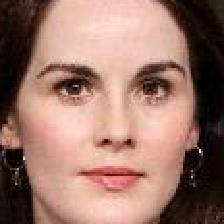

Ground Truth 1.0
Prediction 0


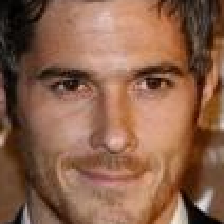

Ground Truth 1.0
Prediction 0


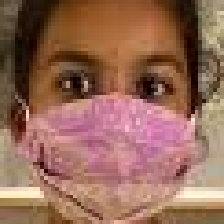

Ground Truth 0.0
Prediction 1


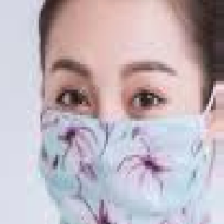

Ground Truth 0.0
Prediction 1


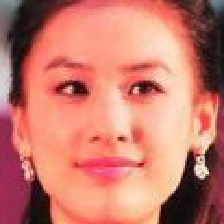

Ground Truth 1.0
Prediction 0


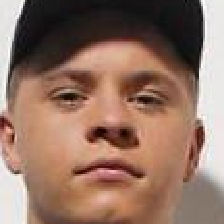

Ground Truth 1.0
Prediction 0


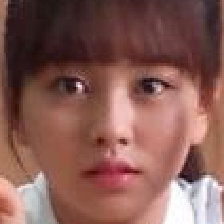

Ground Truth 1.0
Prediction 0


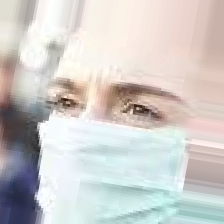

Ground Truth 0.0
Prediction 1


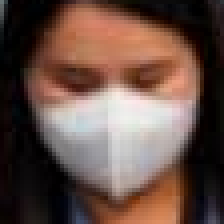

Ground Truth 0.0
Prediction 1


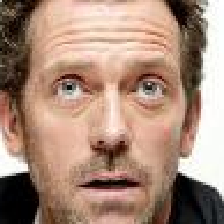

Ground Truth 1.0
Prediction 0


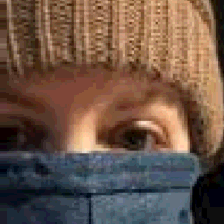

Ground Truth 0.0
Prediction 1


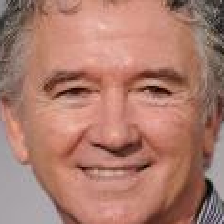

Ground Truth 1.0
Prediction 0


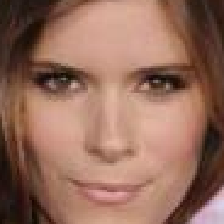

Ground Truth 1.0
Prediction 0


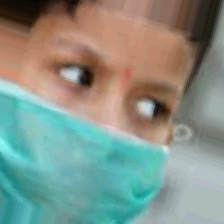

Ground Truth 0.0
Prediction 1


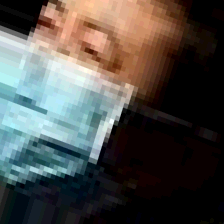

Ground Truth 0.0
Prediction 1


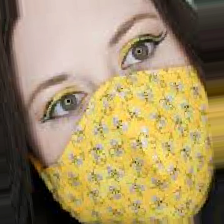

Ground Truth 0.0
Prediction 1


In [ ]:
# Predictions of Validation data set(Dev) - visualisation

i = 0
for batch in val_dataset:
  for i in range(batch_size):
    rgb_image = batch[0][i]
    label = batch[1][i].numpy()[0]
    bgr_image = cv2.cvtColor(rgb_image.numpy(), cv2.COLOR_RGB2BGR)
    cv2_imshow(bgr_image)
    print("Ground Truth", label)
    print("Prediction", np.argmax(mmodel.predict_single(rgb_image)))
    i+=1
  if i>=10:
    break

## More inference

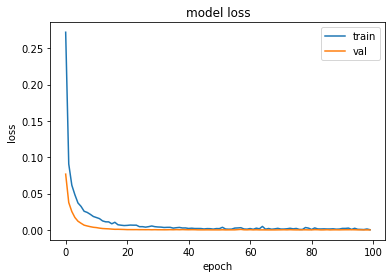

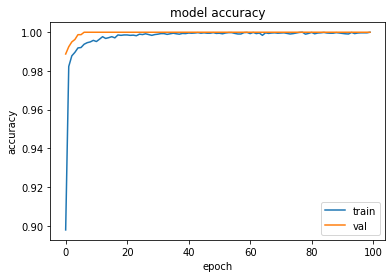

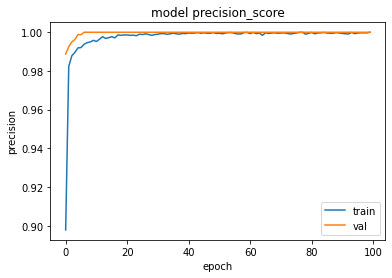

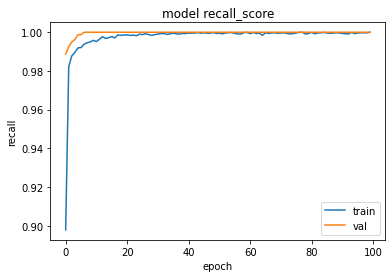

In [ ]:
# Drawing the train Loss, accuracy, f1, precision, recall of the model - visualising

mmodel.plot_loss_per_epoch()
mmodel.plot_accuracy_per_epoch()
mmodel.plot_precision_per_epoch()
mmodel.plot_recall_per_epoch()

## Saving Model

In [ ]:
# saving model to file

mmodel.write_model_with_weights_to_file('facemask12k_100epochs_xception_224_rescaled.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
from google.colab import files
files.download('facemask12k_100epochs_xception_224_rescaled.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>